### GPU setup

In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow[and-cuda]

In [1]:
import tensorflow as tf

2025-07-19 21:07:02.058942: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 21:07:02.367087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752977222.525695  305998 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752977222.560795  305998 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752977222.785707  305998 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA:  True


In [3]:
import subprocess
import sys

# Check NVIDIA driver
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    print("NVIDIA-SMI output:")
    print(result.stdout)
except FileNotFoundError:
    print("nvidia-smi not found. NVIDIA drivers may not be installed.")


NVIDIA-SMI output:
Sat Jul 19 21:07:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.65                 Driver Version: 566.07         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   58C    P8              5W /   40W |    2085MiB /   4096MiB |     33%      Default |
|                                         |                        |                  N/A |
+----------------------------

--- 

## Loading data into tensorflow for training

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt

In [5]:
images_path = 'raw_data/archive/train'

img_height = 48
img_width = 48

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=420,
    image_size=(img_height, img_width),
    batch_size=32,
    color_mode='grayscale'
)

Found 28273 files belonging to 6 classes.
Using 22619 files for training.


I0000 00:00:1752977233.799265  305998 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=420,
    image_size=(img_height, img_width),
    batch_size=32,
    color_mode='grayscale'
)

Found 28273 files belonging to 6 classes.
Using 5654 files for validation.


In [7]:
train_dataset.class_names

['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [53]:
validation_dataset.class_names

['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [61]:
for images, labels in train_dataset:
    print(images.shape)
    break

(32, 48, 48, 1)


#### HEADS UP!
We're going to discard the disgust feeling due to the fact that there is not enough images to be fairly trained against the others sentiments.

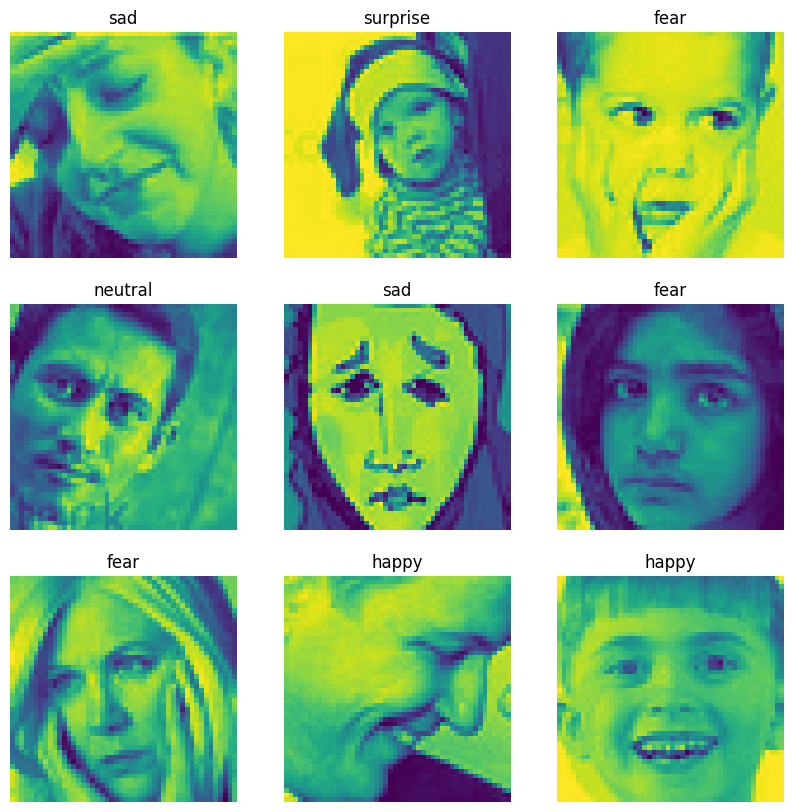

In [60]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_dataset.class_names[labels[i]])
        plt.axis("off")

In [9]:
for images, labels in train_dataset.take(1):
    print(images.shape)
    break

(32, 48, 48, 1)


---
## Starting off with the CNN model

In [ ]:

train_dataset_filtered = train_dataset
validation_dataset_filtered = validation_dataset

In [11]:
# Checking what are the types of the datasets
print("Type of train_dataset_filtered and train_dataset:")
print(type(train_dataset_filtered) == type(train_dataset))
print(type(train_dataset_filtered))
print(type(train_dataset))

Type of train_dataset_filtered and train_dataset:
True
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [12]:
for images, labels in train_dataset_filtered:
    conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(img_height, img_width, 1))
    fmaps = conv_layer(images)  

/home/salos/.pyenv/versions/3.12.9/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752977238.226383  305998 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-19 21:07:25.215127: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


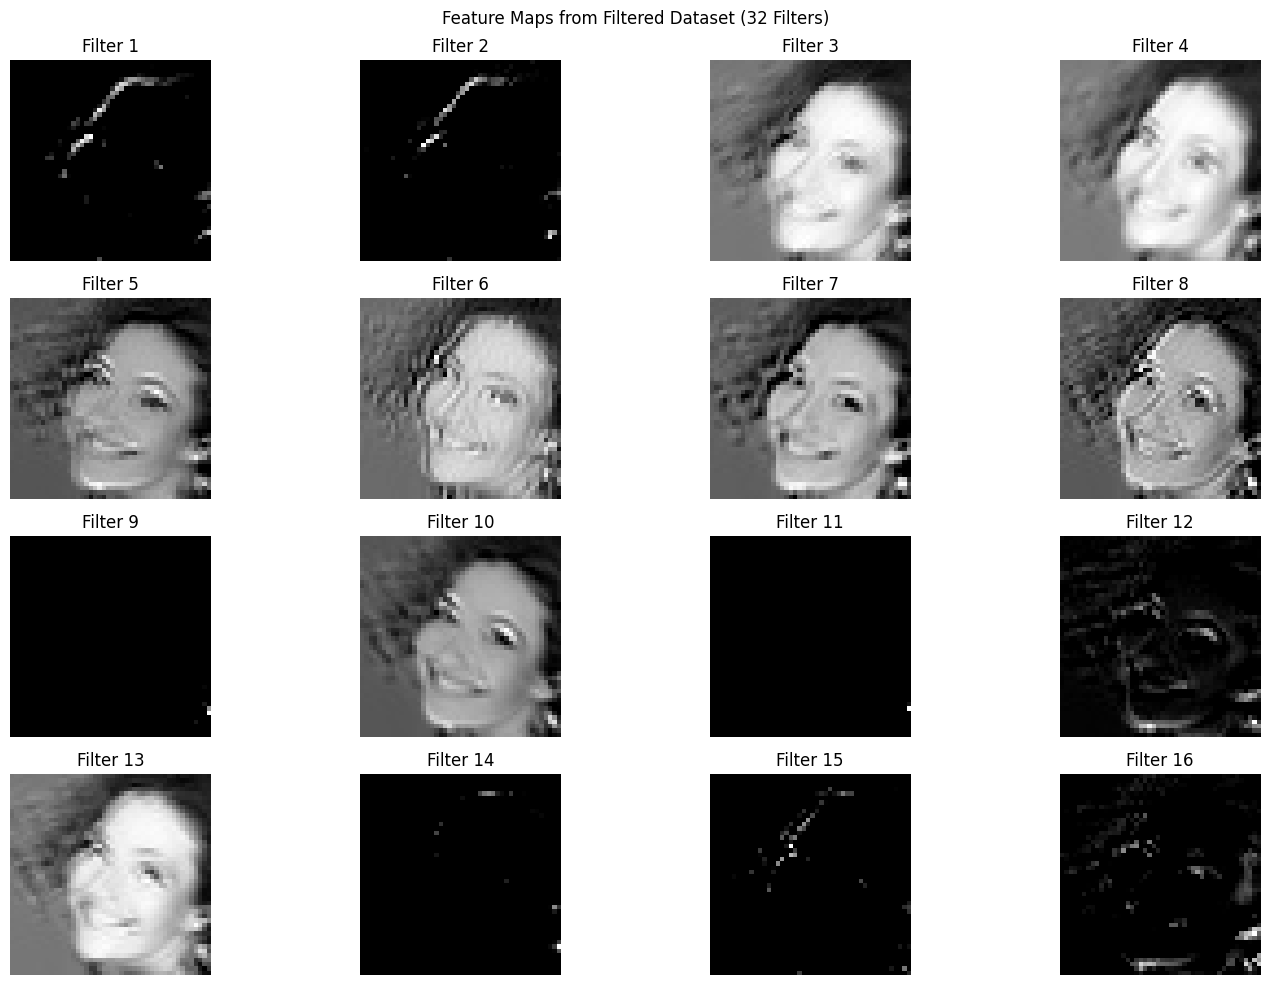

In [13]:
plt.figure(figsize=(15, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fmaps[4, :, :, i], cmap='gray')
    plt.title(f'Filter {i+1}')
    plt.axis('off')
plt.suptitle('Feature Maps from Filtered Dataset (32 Filters)')
plt.tight_layout()
plt.show()

In [90]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')

# Common CNN architecture for grayscale emotion recognition
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 1)),
    tf.keras.layers.Rescaling(1./255),
    DefaultConv2D(filters=64, kernel_size=(5,5)),
    tf.keras.layers.MaxPooling2D(2, 2),
    DefaultConv2D(filters = 128),
    DefaultConv2D(filters = 128),
    tf.keras.layers.MaxPooling2D(2, 2),
    DefaultConv2D(filters = 256),
    DefaultConv2D(filters = 256),
    # tf.keras.layers.MaxPooling2D(2, 2),
    # DefaultConv2D(filters = 512),
    # DefaultConv2D(filters = 512),
    # tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.GlobalAvgPool2D(),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=6, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_751 (Conv2D)             │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_752 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_753 (Conv2D)             │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_754 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_755 (Conv2D)             │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,149,894 (4.39 MB)

 Trainable params: 1,149,894 (4.39 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights to balance training
y_train = []
for images, labels in train_dataset_filtered:
    y_train.extend(labels.numpy())

y_train = np.array(y_train)
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weight_dict = dict(zip(unique_classes, class_weights))

print(f"\nClass weights: {class_weight_dict}")


Class weights: {np.int32(0): np.float64(1.1769695077531481), np.int32(1): np.float64(1.1514457340663815), np.int32(2): np.float64(0.6476264101242627), np.int32(3): np.float64(0.956082509087835), np.int32(4): np.float64(0.9807058619493583), np.int32(5): np.float64(1.48770060510392)}


## Training the model

In [92]:
EPOCHS = 13
BATCH_SIZE = 32

history = model.fit(
    train_dataset_filtered,
    validation_data=validation_dataset_filtered,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict 
)

print("Training completed! Lets go!")

Epoch 1/13


707/707 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.1750 - loss: 1.8020 - val_accuracy: 0.1744 - val_loss: 1.7933
Epoch 2/13
707/707 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.1626 - loss: 1.7877 - val_accuracy: 0.1831 - val_loss: 1.7848
Epoch 3/13
707/707 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.1895 - loss: 1.7767 - val_accuracy: 0.2052 - val_loss: 1.7666
Epoch 4/13
707/707 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.2154 - loss: 1.7234 - val_accuracy: 0.2692 - val_loss: 1.6277
Epoch 5/13
707/707 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.2992 - loss: 1.6032 - val_accuracy: 0.3801 - val_loss: 1.5273
Epoch 6/13
707/707 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.3681 - loss: 1.5143 - val_accuracy: 0.4165 - val_loss: 1.3848
Epoch 7/13
707/707 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.4288 - loss: 1.4106 - val_accuracy: 0.4471 - val_loss: 1.3289
Epoch 8/13
707/707 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.4622 - loss: 1.3443 - val_accurac

In [93]:
print("=== Model Evaluation ===")

val_loss, val_accuracy = model.evaluate(validation_dataset_filtered, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("\n=== Detailed Validation Analysis ===")
y_true = []
y_pred = []

for images, labels in validation_dataset_filtered:
    # print(f" Labels shape: {labels}")
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy manually
accuracy = np.mean(y_true == y_pred)
print(f"Manual accuracy calculation: {accuracy:.4f}")

# Show classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=[train_dataset.class_names[i] for i in sorted(set(y_true))]))

=== Model Evaluation ===
  1/177 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6250 - loss: 1.2441

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5299 - loss: 1.3233

Validation Loss: 1.3102
Validation Accuracy: 0.5368

=== Detailed Validation Analysis ===
Manual accuracy calculation: 0.5368

=== Classification Report ===
              precision    recall  f1-score   support

       angry       0.41      0.57      0.48       792
        fear       0.36      0.30      0.33       823
       happy       0.81      0.74      0.77      1394
     neutral       0.56      0.37      0.45      1022
         sad       0.37      0.44      0.40       986
    surprise       0.65      0.78      0.71       637

    accuracy                           0.54      5654
   macro avg       0.53      0.53      0.52      5654
weighted avg       0.55      0.54      0.54      5654



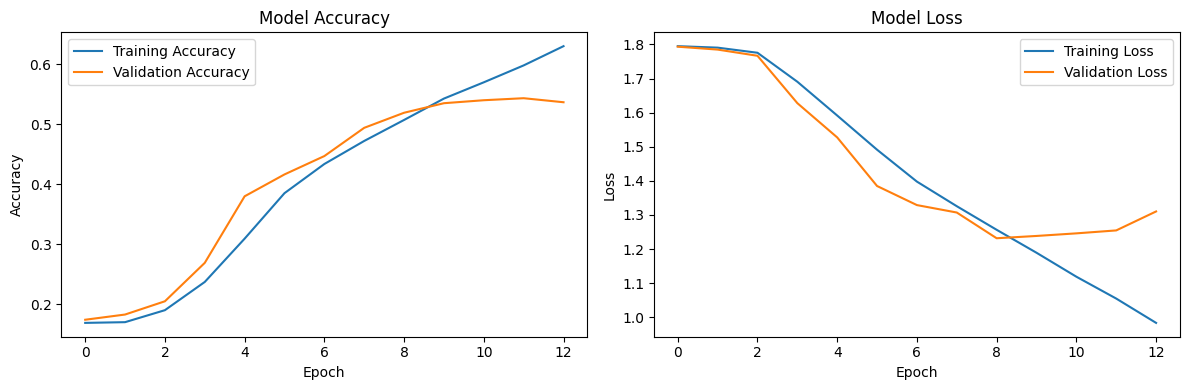

In [94]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

=== Testing Individual Predictions ===


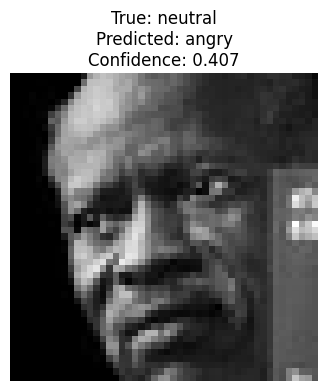

Image 1: True=3, Predicted=0, Correct=False


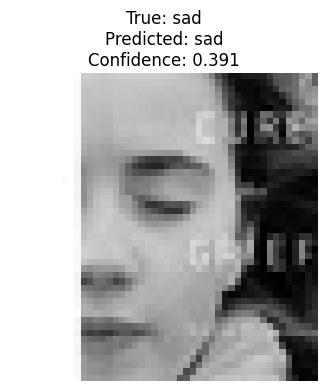

Image 2: True=4, Predicted=4, Correct=True


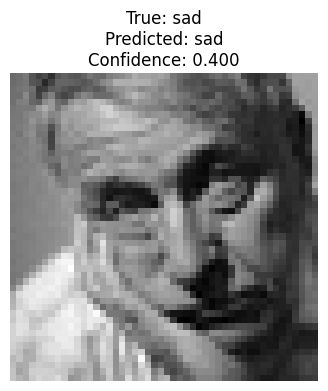

Image 3: True=4, Predicted=4, Correct=True


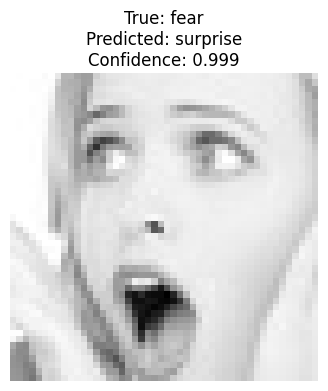

Image 4: True=1, Predicted=5, Correct=False


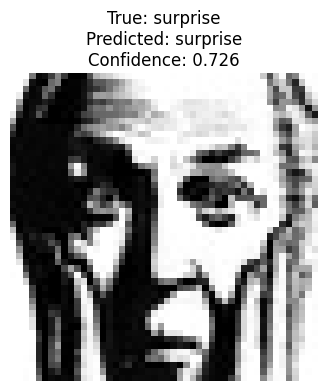

Image 5: True=5, Predicted=5, Correct=True


In [95]:
print("=== Testing Individual Predictions ===")

for images, labels in validation_dataset_filtered:
    # Test first 5 images in the batch
    for i in range(min(5, len(images))):
        single_image = images[i:i+1]
        true_label = labels[i].numpy()
        
        prediction = model.predict(single_image, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = np.max(prediction[0])
        
        plt.figure(figsize=(6, 4))
        plt.imshow(single_image[0, :, :, 0], cmap='gray')
        plt.title(f"True: {train_dataset.class_names[true_label]}\n"
                 f"Predicted: {train_dataset.class_names[predicted_class]}\n"
                 f"Confidence: {confidence:.3f}")
        plt.axis('off')
        plt.show()
        
        print(f"Image {i+1}: True={true_label}, Predicted={predicted_class}, Correct={true_label==predicted_class}")
    break

In [96]:
predictions = model.predict(validation_dataset_filtered, verbose=1)

177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [97]:
import pickle

# Save model with metadata
model.save('emotion_model.h5')

# Save important metadata
metadata = {
    'class_names': [name for i, name in enumerate(train_dataset.class_names)],
    'img_height': img_height,
    'img_width': img_width,
    'num_classes': 6,
    'class_weights': class_weight_dict
}

with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("Model and metadata saved!")


Model and metadata saved!


In [ ]:
for images, labels in train_dataset_filtered.take(1):
    print(images.shape)
    break

(32, 48, 48, 1)
